In [ ]:
# @title Default title text
import os
import shutil
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("samaneheslamifar/facial-emotion-expressions")
print("Path to dataset files:", path)

# Define the original folders to search through
original_dirs = [
    os.path.join(path, "images", "images"),  # e.g., images/images/train
    os.path.join(path, "images"),           # e.g., images/train
]

# Create clean target directory
base_dir = "facial_emotion_data"
for split in ["train", "validation", "test"]:
    for emotion in ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]:
        os.makedirs(os.path.join(base_dir, split, emotion), exist_ok=True)

# Copy files from all train/validation sources into the new structure
for orig_base in original_dirs:
    for split in ["train", "validation"]:
        split_path = os.path.join(orig_base, split)
        if os.path.exists(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                if os.path.isdir(emotion_path):
                    dest_dir = os.path.join(base_dir, split, emotion)
                    for img in os.listdir(emotion_path):
                        src_img_path = os.path.join(emotion_path, img)
                        dst_img_path = os.path.join(dest_dir, img)
                        if not os.path.exists(dst_img_path):  # avoid duplicate copies
                            shutil.copy(src_img_path, dst_img_path)

print("Dataset has been cleaned and organized into:", base_dir)


In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, SeparableConv2D,
    MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define constants
IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 7
EMOTION_CLASSES = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def create_mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    """
    Create a mini-XCEPTION model as defined in the second document
    Uses separable convolutions and residual connections for better efficiency

    Note: Updated parameter names for TensorFlow 2.x compatibility
    """
    regularization = l2(l2_regularization)

    # Base of the model
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Fixed: Using depthwise_regularizer and pointwise_regularizer instead of kernel_regularizer
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)

    # Compile model with same settings as original
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_emotion_cnn():
    """
    Original CNN model for facial emotion recognition.
    This is kept for comparison purposes.
    """
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_emotion_model(train_dir, validation_dir, test_dir=None, use_xception=True):
    """
    Train the emotion recognition model using data from directories

    Parameters:
    - train_dir: Directory containing training data organized in emotion folders
    - validation_dir: Directory containing validation data organized in emotion folders
    - test_dir: Optional directory containing test data
    - use_xception: If True, use mini-XCEPTION model, otherwise use the original CNN

    Returns:
    - Trained model and training history
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation/test
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical',
        classes=EMOTION_CLASSES
    )

    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical',
        classes=EMOTION_CLASSES
    )

    # Create model - either mini-XCEPTION or original CNN
    if use_xception:
        model = create_mini_XCEPTION(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES)
        model_name = 'emotion_xception_model'
    else:
        model = create_emotion_cnn()
        model_name = 'emotion_cnn_model'

    print(model.summary())

    # Callbacks for better training
    callbacks = [
        ModelCheckpoint(
            filepath=f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks
    )

    # Evaluate on test set if provided
    if test_dir:
        test_generator = val_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            color_mode='grayscale',
            class_mode='categorical',
            classes=EMOTION_CLASSES,
            shuffle=False
        )

        test_loss, test_acc = model.evaluate(test_generator)
        print(f"Test accuracy: {test_acc:.4f}")

    # Save the final model
    model.save(f'{model_name}.h5')

    return model, history

def plot_training_history(history, model_name='model'):
    """Plot training & validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

def predict_emotion(image_path, model):
    """
    Predict emotion for a single image

    Parameters:
    - image_path: Path to image file
    - model: Trained emotion recognition model

    Returns:
    - Predicted emotion label and probabilities
    """
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    emotion_label = EMOTION_CLASSES[predicted_class]
    probabilities = {EMOTION_CLASSES[i]: float(predictions[0][i]) for i in range(len(EMOTION_CLASSES))}

    return emotion_label, probabilities

def compare_models(train_dir, validation_dir, test_dir=None):
    """
    Train and compare both models: original CNN and mini-XCEPTION

    Parameters:
    - train_dir: Directory containing training data
    - validation_dir: Directory containing validation data
    - test_dir: Optional directory containing test data

    Returns:
    - Dictionary with models and their histories
    """
    results = {}

    # Train original CNN model
    print("Training original CNN model...")
    cnn_model, cnn_history = train_emotion_model(
        train_dir, validation_dir, test_dir, use_xception=False
    )
    plot_training_history(cnn_history, model_name='original_cnn')
    results['cnn'] = {'model': cnn_model, 'history': cnn_history}

    # Train mini-XCEPTION model
    print("Training mini-XCEPTION model...")
    xception_model, xception_history = train_emotion_model(
        train_dir, validation_dir, test_dir, use_xception=True
    )
    plot_training_history(xception_history, model_name='mini_xception')
    results['xception'] = {'model': xception_model, 'history': xception_history}

    # Compare final validation accuracies
    cnn_val_acc = cnn_history.history['val_accuracy'][-1]
    xception_val_acc = xception_history.history['val_accuracy'][-1]

    print(f"Final validation accuracy comparison:")
    print(f"Original CNN: {cnn_val_acc:.4f}")
    print(f"mini-XCEPTION: {xception_val_acc:.4f}")

    return results

# Example usage:
if __name__ == "__main__":
    # Assuming your dataset is organized like:
    # data/
    #   train/
    #     angry/
    #     disgust/
    #     ...
    #   validation/
    #     angry/
    #     disgust/
    #     ...
    #   test/ (optional)
    #     ...

    base_dir = "data"  # Change this to your data directory
    train_dir = os.path.join(base_dir, "train")
    validation_dir = os.path.join(base_dir, "validation")
    test_dir = os.path.join(base_dir, "test")  # Optional

    # Option 1: Train just the mini-XCEPTION model
    model, history = train_emotion_model(train_dir, validation_dir, test_dir, use_xception=True)
    plot_training_history(history, model_name='mini_xception')

    # Option 2: Compare both models
    # results = compare_models(train_dir, validation_dir, test_dir)

    # Example of prediction (uncomment to use)
    # test_image_path = "path/to/test/image.jpg"
    # emotion, probs = predict_emotion(test_image_path, model)
    # print(f"Predicted emotion: {emotion}")
    # print(f"Probabilities: {probs}")

In [ ]:
# @title
# STEP 1: Install required packages
!pip install tensorflow keras pandas numpy matplotlib scikit-learn


In [ ]:
# @title
# STEP 2: Upload your kaggle.json to use Kaggle API
from google.colab import files
files.upload()  # upload kaggle.json here

# Move it to ~/.kaggle and change permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip


In [ ]:
# @title
# STEP 3: Load dataset using ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/train'
val_dir = 'data/validation'
test_dir = 'data/test'

# Image dimensions
img_size = (48, 48)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Confirm classes
print("Class indices:", train_generator.class_indices)


In [ ]:
# @title
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))  # 7 emotion classes


In [ ]:
# @title
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Optional callbacks
checkpoint = ModelCheckpoint(
    'emotion_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train using generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


In [ ]:
# @title
# Save the final model
model.save('emotion_model_final2.h5')


In [ ]:
# @title
import os
import shutil

val_path = 'data/validation'
test_path = 'data/test'

# Make test folder structure
os.makedirs(test_path, exist_ok=True)

for emotion in os.listdir(val_path):
    os.makedirs(os.path.join(test_path, emotion), exist_ok=True)


In [ ]:
# @title
import random

for emotion in os.listdir(val_path):
    val_emotion_path = os.path.join(val_path, emotion)
    test_emotion_path = os.path.join(test_path, emotion)

    files = os.listdir(val_emotion_path)
    random.shuffle(files)

    num_to_move = int(0.2 * len(files))  # 20%

    for f in files[:num_to_move]:
        src = os.path.join(val_emotion_path, f)
        dst = os.path.join(test_emotion_path, f)
        shutil.move(src, dst)

    print(f"Moved {num_to_move} images from {emotion}")


In [ ]:
# @title
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (48, 48)
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)

val_generator = datagen.flow_from_directory(
    'data/validation',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    'data/test',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


In [ ]:
# @title
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples
)

print(f"Test Accuracy: {test_acc * 100:.2f}%")


In [ ]:
# @title
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam

# Inputs: replicate grayscale channel to RGB
input_layer = Input(shape=(48, 48, 1))
x = Conv2D(3, (3, 3), padding='same')(input_layer)  # Convert to 3 channels

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
base_model.trainable = False  # Freeze base

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# @title
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


In [ ]:
# @title
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true and predicted labels
Y_pred = model.predict(test_generator, steps=test_generator.samples)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


xception


In [ ]:
# @title
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from models.cnn import mini_XCEPTION
from tensorflow.keras.optimizers import Adam
import os

# Parameters
batch_size = 32
num_epochs = 551
input_shape = (48, 48, 1)
validation_split = 0.2
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'

# Image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=validation_split
)

# Data generators from folders
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=input_shape[:2],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=input_shape[:2],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Model setup
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
log_file_path = os.path.join(base_path, 'emotion_training.log')
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience / 4), verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(base_path, 'mini_XCEPTION.{epoch:02d}.hdf5'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

# Training
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks
)


final


FER2013 dataset found in Colab runtime.
Loading dataset...
Dataset loaded: 35887 samples, 7 classes


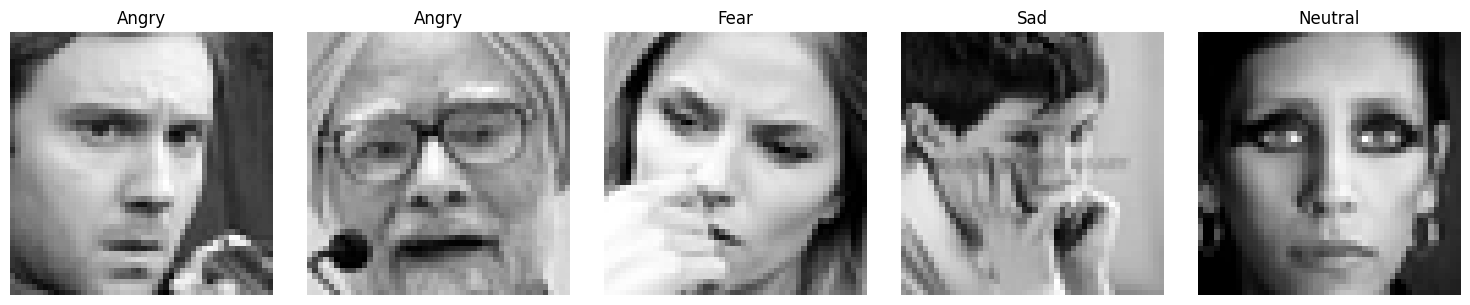

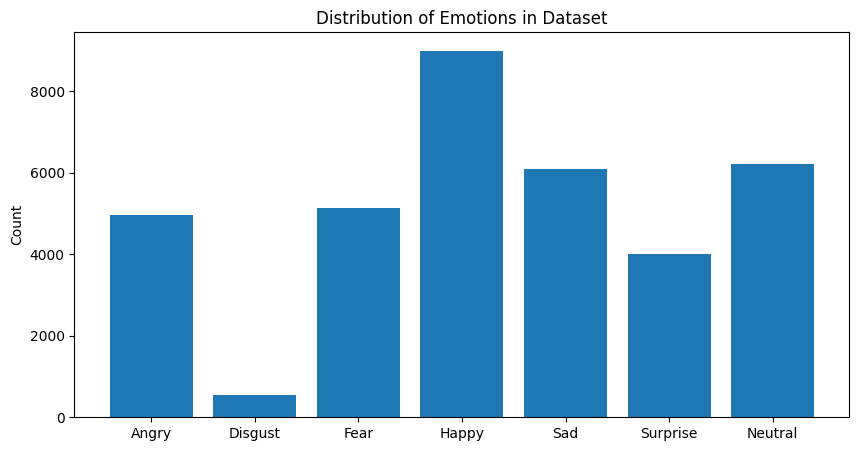

Train set: 28709 samples
Test set: 7178 samples


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 46, 46, 8)      │             72 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_142   │ (None, 46, 46, 8)      │             32 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_121            │ (None, 46, 46, 8)      │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 44, 44, 8)      │            576 │ activation_121[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_143   │ (None, 44, 44, 8)      │             32 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_122            │ (None, 44, 44, 8)      │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_92       │ (None, 44, 44, 16)     │            200 │ activation_122[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_145   │ (None, 44, 44, 16)     │             64 │ separable_conv2d_92[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_123            │ (None, 44, 44, 16)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_93       │ (None, 44, 44, 16)     │            400 │ activation_123[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_146   │ (None, 44, 44, 16)     │             64 │ separable_conv2d_93[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 22, 22, 16)     │            128 │ activation_122[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_51          │ (None, 22, 22, 16)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

Training the model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


895/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2970 - loss: 4.0685
Epoch 1: val_loss improved from inf to 1.93284, saving model to models/mini_XCEPTION.01-1.93.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.2972 - loss: 4.0648 - val_accuracy: 0.4145 - val_loss: 1.9328 - learning_rate: 0.0010
Epoch 2/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1562 - loss: 2.3746

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.93284 to 1.92640, saving model to models/mini_XCEPTION.02-1.93.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1562 - loss: 2.3746 - val_accuracy: 0.4156 - val_loss: 1.9264 - learning_rate: 0.0010
Epoch 3/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4277 - loss: 1.7947
Epoch 3: val_loss did not improve from 1.92640
897/897 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.4277 - loss: 1.7946 - val_accuracy: 0.2604 - val_loss: 2.2001 - learning_rate: 0.0010
Epoch 4/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5000 - loss: 1.6462
Epoch 4: val_loss did not improve from 1.92640
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.5000 - loss: 1.6462 - val_accuracy: 0.2587 - val_loss: 2.2098 - learning_rate: 0.0010
Epoch 5/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4607 - loss: 1.5795
Epoch 5: val_loss improved from 1.92640 to 1.51432, saving model to models/mini_XCEPTION.05-1.51.keras
897/897

Model training completed and saved as 'emotion_recognition_model.h5'


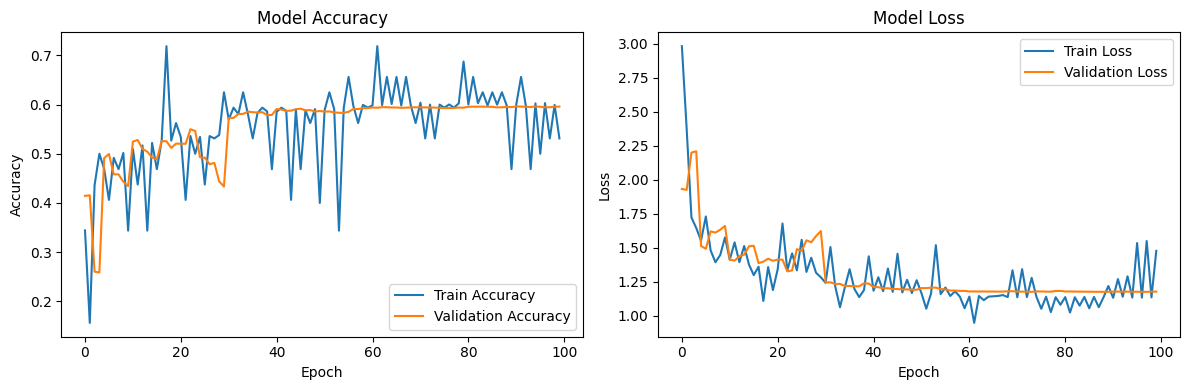

Testing the model with sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


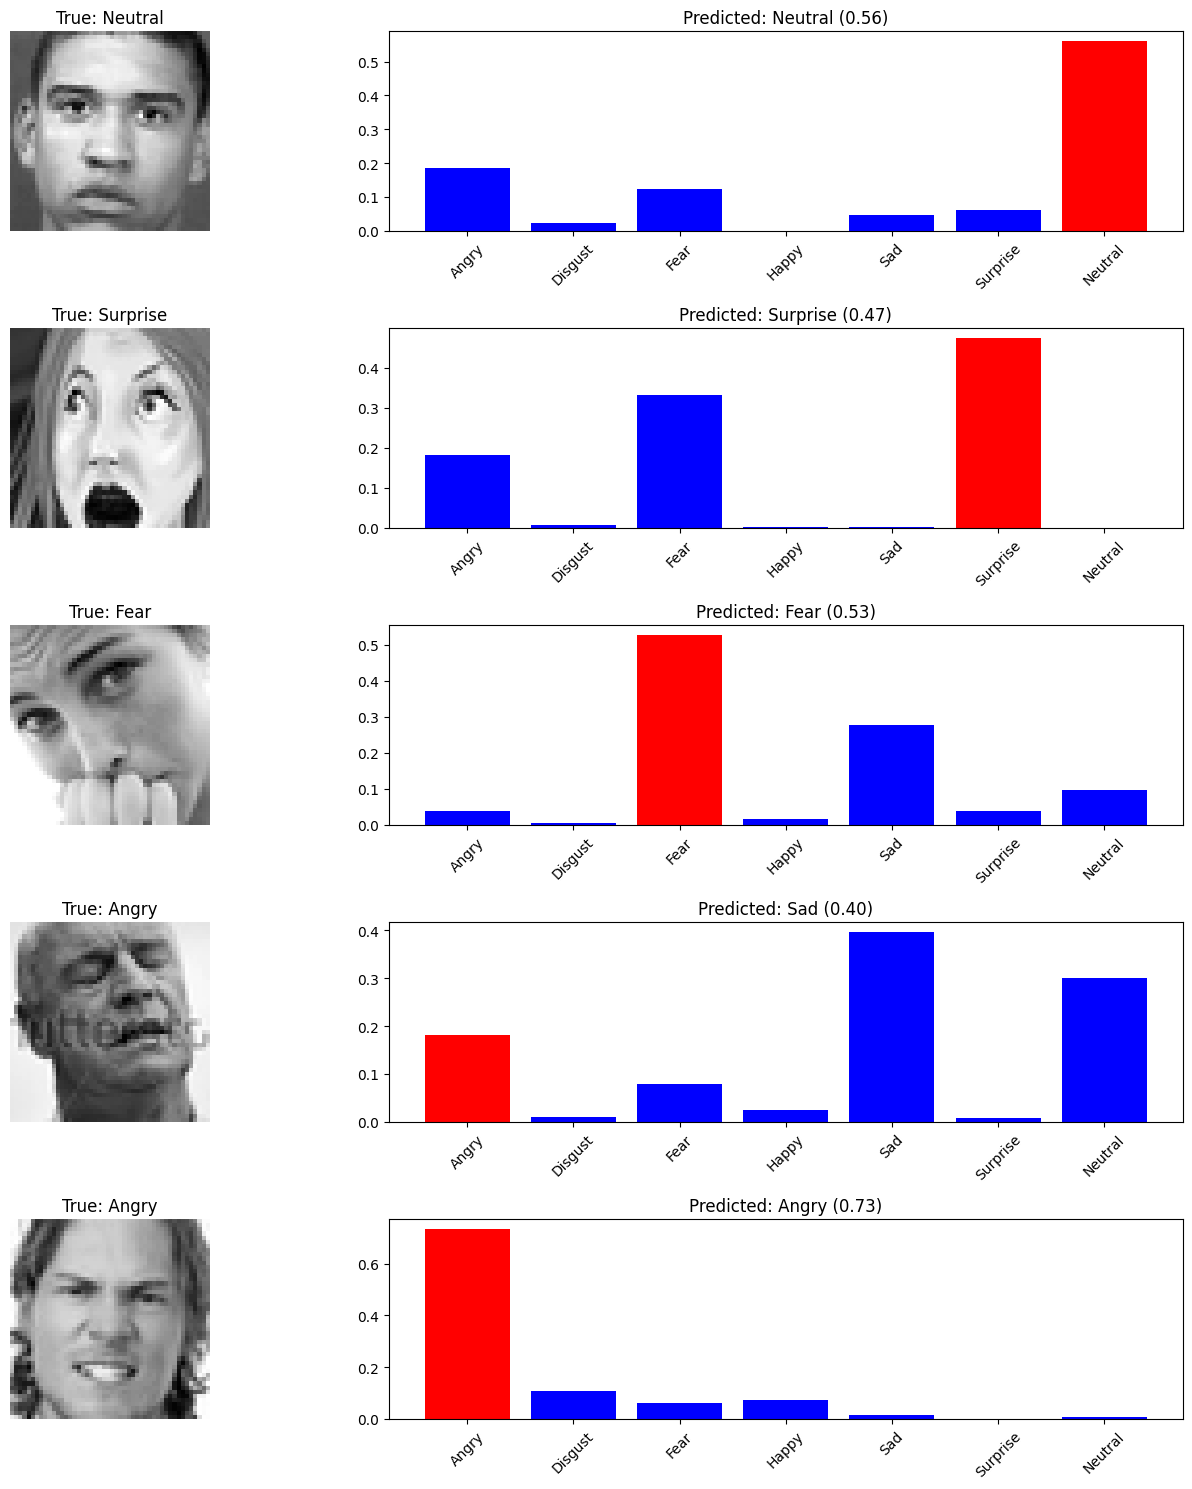


Evaluating model performance...
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.54      0.49       910
     Disgust       0.51      0.14      0.22       130
        Fear       0.43      0.27      0.33      1029
       Happy       0.85      0.81      0.83      1856
         Sad       0.49      0.50      0.49      1204
    Surprise       0.71      0.73      0.72       804
     Neutral       0.50      0.64      0.57      1245

    accuracy                           0.60      7178
   macro avg       0.56      0.52      0.52      7178
weighted avg       0.60      0.60      0.59      7178


Test accuracy: 0.5958
Test loss: 1.1781
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


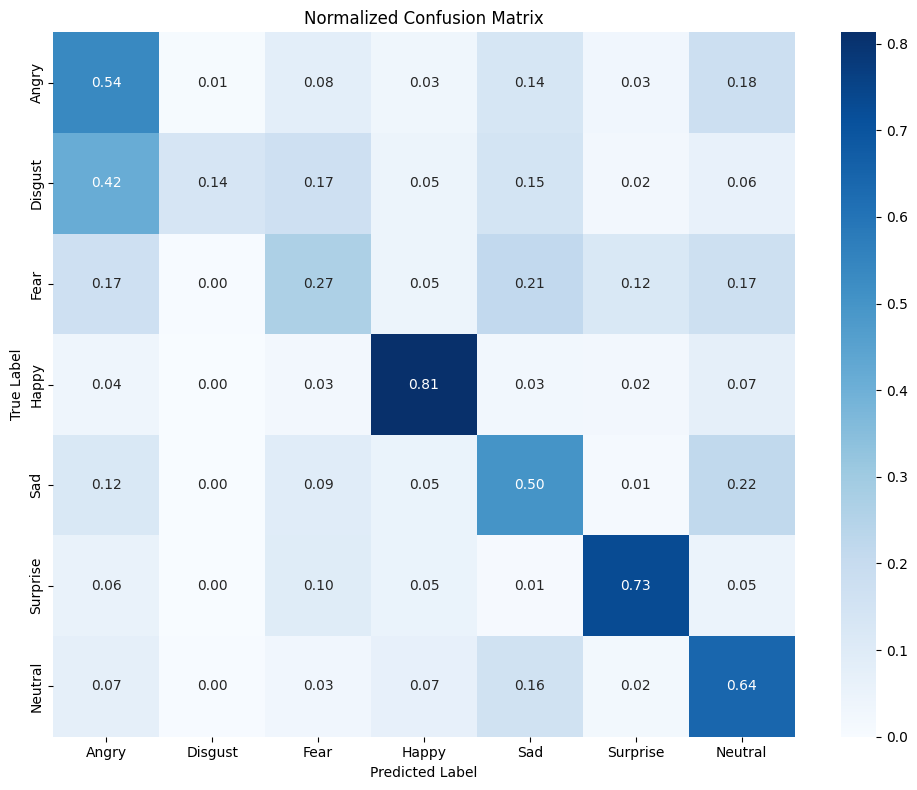

Per-class accuracy:
Angry: 0.5352
Disgust: 0.1385
Fear: 0.2682
Happy: 0.8130
Sad: 0.4992
Surprise: 0.7301
Neutral: 0.6418

You can test individual images using:
test_single_image(image_index)  # Replace image_index with a number between 0 and 7177


In [42]:
# Emotion Recognition with mini-XCEPTION Model in Google Colab
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Create a models directory in runtime
os.makedirs('models', exist_ok=True)

# Function to load and preprocess the FER2013 dataset
def load_fer2013():
    data = pd.read_csv('fer2013.csv')
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)

    emotions = pd.get_dummies(data['emotion']).values

    return faces, emotions

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # Base of the model
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Fixed: Changed kernel_regularizer to depthwise_regularizer and pointwise_regularizer
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

# Verify that dataset exists in the runtime
if os.path.exists('fer2013.csv'):
    print("FER2013 dataset found in Colab runtime.")
else:
    print("Error: fer2013.csv not found. Please ensure it's uploaded to the Colab runtime.")

# Parameters
batch_size = 32
num_epochs = 100  # Adjust as needed
input_shape = (48, 48, 1)
validation_split = 0.2
verbose = 1
num_classes = 7  # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
patience = 30
base_path = 'models/'

# Data generator for augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# Loading dataset
print("Loading dataset...")
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
print(f"Dataset loaded: {num_samples} samples, {num_classes} classes")

# Let's visualize some samples from the dataset
def plot_sample_images(faces, emotions, n_images=5):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        face = faces[i].squeeze()
        emotion_idx = np.argmax(emotions[i])
        plt.imshow(face, cmap='gray')
        plt.title(f"{emotion_labels[emotion_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(faces, emotions)

# Distribution of emotions in the dataset
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_counts = emotions.sum(axis=0)
plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, emotion_counts)
plt.title('Distribution of Emotions in Dataset')
plt.ylabel('Count')
plt.show()

# Split the dataset
xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=0.2, shuffle=True)
print(f"Train set: {xtrain.shape[0]} samples")
print(f"Test set: {xtest.shape[0]} samples")

# Create and compile model
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
log_file_path = base_path + 'emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                             patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.keras'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

# Train the model
print("Training the model...")
history = model.fit(
    data_generator.flow(xtrain, ytrain, batch_size=batch_size),
    steps_per_epoch=len(xtrain) // batch_size,
    epochs=num_epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=(xtest, ytest)
)

# Save the final model
model.save('emotion_recognition_model.h5')
print("Model training completed and saved as 'emotion_recognition_model.h5'")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Test with sample images from test set
def test_with_samples(num_samples=5):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Get random samples from test set
    indices = np.random.choice(range(len(xtest)), num_samples, replace=False)
    test_faces = xtest[indices]
    test_emotions = ytest[indices]

    # Make predictions
    predictions = model.predict(test_faces)

    # Display results
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(test_faces[i].squeeze(), cmap='gray')
        true_emotion = emotion_labels[np.argmax(test_emotions[i])]
        plt.title(f"True: {true_emotion}")
        plt.axis('off')

        plt.subplot(num_samples, 2, i*2+2)
        prediction = predictions[i]
        emotion_probs = dict(zip(emotion_labels, prediction))
        colors = ['red' if k == true_emotion else 'blue' for k in emotion_labels]
        plt.bar(emotion_labels, prediction, color=colors)
        pred_emotion = emotion_labels[np.argmax(prediction)]
        plt.title(f"Predicted: {pred_emotion} ({prediction.max():.2f})")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Test the model with some samples from the test set
print("Testing the model with sample images...")
test_with_samples(5)

# Function to test with a single image
def test_single_image(image_idx):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Get the image
    test_face = xtest[image_idx:image_idx+1]
    test_emotion = ytest[image_idx:image_idx+1]

    # Make prediction
    prediction = model.predict(test_face)[0]

    # Display result
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_face[0].squeeze(), cmap='gray')
    true_emotion = emotion_labels[np.argmax(test_emotion[0])]
    plt.title(f"True: {true_emotion}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    colors = ['red' if k == true_emotion else 'blue' for k in emotion_labels]
    plt.bar(emotion_labels, prediction, color=colors)
    pred_emotion = emotion_labels[np.argmax(prediction)]
    plt.title(f"Predicted: {pred_emotion} ({prediction.max():.2f})")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print prediction details
    print(f"True emotion: {true_emotion}")
    print(f"Predicted emotion: {pred_emotion} (confidence: {prediction.max():.2f})")
    print("\nDetailed probabilities:")
    for i, emotion in enumerate(emotion_labels):
        print(f"{emotion}: {prediction[i]:.4f}")

# Calculate and display confusion matrix
def plot_confusion_matrix():
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Get predictions
    y_pred = model.predict(xtest)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(ytest, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Print accuracy for each class
    print("Per-class accuracy:")
    for i, emotion in enumerate(emotion_labels):
        class_accuracy = cm_normalized[i, i]
        print(f"{emotion}: {class_accuracy:.4f}")

# Calculate and display evaluation metrics
def evaluate_model():
    from sklearn.metrics import classification_report

    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Get predictions
    y_pred = model.predict(xtest)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(ytest, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))

    # Calculate and print overall accuracy
    test_loss, test_acc = model.evaluate(xtest, ytest, verbose=0)
    print(f"\nTest accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

# Evaluate the model
print("\nEvaluating model performance...")
evaluate_model()
plot_confusion_matrix()

print("\nYou can test individual images using:")
print("test_single_image(image_index)  # Replace image_index with a number between 0 and", len(xtest)-1)